In [1]:
import sys
import pathlib
import yaml
import subprocess

import pandas as pd
import numpy as np
import scanpy as sc
import anndata as ad

In [2]:
# Get the root directory of the analysis repository
REPO_ROOT = subprocess.run(
    ["git", "rev-parse", "--show-toplevel"], capture_output=True, text=True
).stdout.strip()
REPO_ROOT = pathlib.Path(REPO_ROOT)

CONFIG_FILE = REPO_ROOT / 'config.yml'
assert CONFIG_FILE.exists(), f"Config file not found at {CONFIG_FILE}"

with open(CONFIG_FILE, 'r') as file:
    config_dict = yaml.safe_load(file)

In [3]:
ACCESSION = config_dict['data_accession']
BIOMART_EXPORT = config_dict['biomart_export_file']

BULK_DATA_PATH = pathlib.Path(config_dict['data_path']['bulk_data_path'])
assert BULK_DATA_PATH.exists(), f"Bulk data path not found at {BULK_DATA_PATH}"

BULK_BLACK_TSV_FILE = BULK_DATA_PATH / 'supp_table_6_black_expr.tsv'
assert BULK_BLACK_TSV_FILE.exists(), f"Black bulk expression data file not found at {BULK_BLACK_TSV_FILE}"
BULK_WHITE_TSV_FILE = BULK_DATA_PATH / 'supp_table_7_white_expr.tsv'
assert BULK_WHITE_TSV_FILE.exists(), f"White bulk expression data file not found at {BULK_WHITE_TSV_FILE}"

BULK_BLACK_METADATA_FILE = BULK_DATA_PATH / 'supp_table_3_main_black_metadata_table.tsv'
assert BULK_BLACK_METADATA_FILE.exists(), f"Black bulk metadata file not found at {BULK_BLACK_METADATA_FILE}"
BULK_WHITE_METADATA_FILE = BULK_DATA_PATH / 'supp_table_4_main_white_metadata_table.tsv'
assert BULK_WHITE_METADATA_FILE.exists(), f"White bulk metadata file not found at {BULK_WHITE_METADATA_FILE}"

In [4]:
analysis_config = config_dict['analysis_config']
GENE_ID_COL = analysis_config['source']['bulk']['var']['gene_id_col'] # 'gene_ids'

## Define save path of output

In [5]:
OUTPUT_PATH = REPO_ROOT / 'processed_data'
if not OUTPUT_PATH.exists():
    OUTPUT_PATH.mkdir(parents=True, exist_ok=True)
assert OUTPUT_PATH.exists(), f"Output path not found at {OUTPUT_PATH}"

In [6]:
bulk_expr_df = pd.DataFrame()
bulk_metadata_df = pd.DataFrame()

for expr_file, metadata_file in zip(
    [BULK_BLACK_TSV_FILE, BULK_WHITE_TSV_FILE], 
    [BULK_BLACK_METADATA_FILE, BULK_WHITE_METADATA_FILE]):

    # Load the expression data

    # Data is originally in the format of genes x samples
    expr_df = pd.read_csv(expr_file, sep='\t', index_col=0)
    expr_df = expr_df.T # Transpose to samples x genes
    expr_df.dropna() # Drop any rows with missing values
    expr_df.index = expr_df.index.str.replace('Sample_', '', regex=False) # Remove the 'Sample_' prefix from the sample IDs

    # Load the metadata
    metadata_df = pd.read_csv(metadata_file, sep='\t', index_col=0)

    # Subset to only the samples that have both expression and metadata
    overlapping_rows = expr_df.index.intersection(metadata_df.index)
    expr_df = expr_df.loc[overlapping_rows]
    metadata_df = metadata_df.loc[overlapping_rows]

    bulk_expr_df = pd.concat([bulk_expr_df, expr_df])
    bulk_metadata_df = pd.concat([bulk_metadata_df, metadata_df])

### Format sample and stim column values as well as remove non-overlapping genes between the B and W dataset

In [7]:
bulk_metadata_df[
    analysis_config['source']['bulk']['obs']['sample_col']
] = bulk_metadata_df.index

bulk_metadata_df[analysis_config['source']['bulk']['obs']['stim_col']] = 'chunk'
# drop columns not in the analysis_config definition
bulk_metadata_df = bulk_metadata_df.loc[:,analysis_config['source']['bulk']['obs'].values()]


bulk_expr_df = bulk_expr_df.dropna(axis=1, how='any')
bulk_expr_df.shape

(588, 18509)

In [8]:
adata = sc.AnnData(bulk_expr_df)
adata.obs = bulk_metadata_df

In [9]:
adata.var[
    analysis_config['source']['bulk']['var']['gene_id_col']
] = adata.var_names

## QC and preprocessing

In [10]:
adata

AnnData object with n_obs × n_vars = 588 × 18509
    obs: 'subject_id', 'dissociation_method'
    var: 'gene_ids'

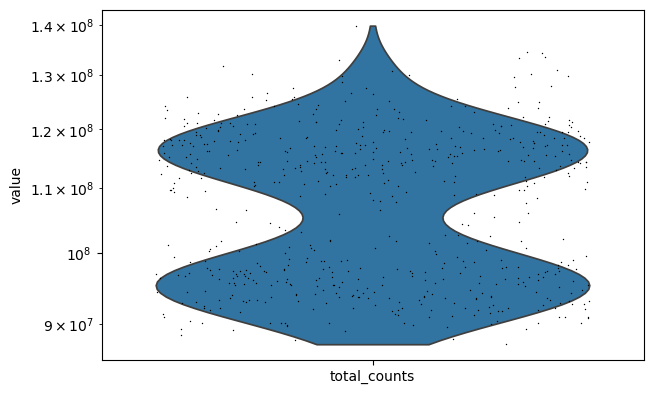

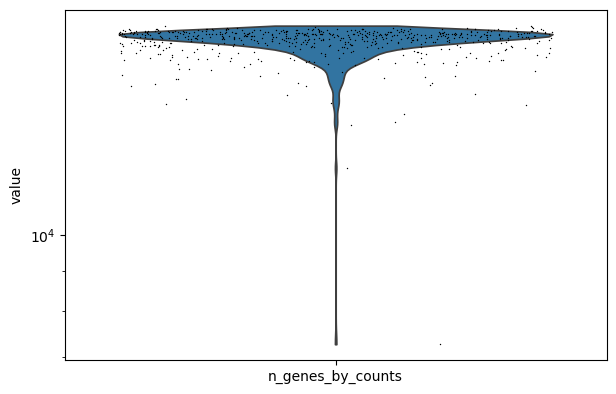

In [11]:
adata.obs["total_counts"] = adata.X.sum(axis=1)
adata.obs["n_genes_by_counts"] = (adata.X > 0).sum(axis=1)
# plot distributions
sc.pl.violin(adata, ["total_counts"], jitter=0.4, log=True)
sc.pl.violin(adata, ["n_genes_by_counts"], jitter=0.4, log=True)

In [12]:
print(f'Number of samples before QC: {adata.shape[0]}')
print(f'Number of genes before QC: {adata.shape[1]}')

sc.pp.filter_cells(adata, min_counts=1e6)
sc.pp.filter_cells(adata, min_genes=5000)
sc.pp.filter_genes(adata, min_cells=3)

print(f'Number of samples after QC: {adata.shape[0]}')
print(f'Number of genes after QC: {adata.shape[1]}')

sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.log1p(adata)

Number of samples before QC: 588
Number of genes before QC: 18509
Number of samples after QC: 588
Number of genes after QC: 18509


In [13]:
adata.write(
    REPO_ROOT / 'processed_data' / 'schildkraut_qc_norm.h5ad'
)